# A/B-тестирование

# Постановка задачи
Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении
есть датасет с действиями пользователей, техническое задание и несколько
вспомогательных датасетов.
* Оцените корректность проведения теста,
* Проанализируйте результаты теста.

Чтобы оценить корректность проведения теста, проверьте:
* Пересечение тестовой аудитории с конкурирующим тестом,
* Совпадение теста и маркетинговых событий,
* Другие проблемы временных границ теста.

# Техническое задание
* Название теста: recommender_system_test;
* группы: А — контрольная, B — новая платёжная воронка;
* дата запуска: 2020-12-07;
* дата остановки набора новых пользователей: 2020-12-21;
* дата остановки: 2021-01-04;
* аудитория: 15% новых пользователей из региона EU;
* назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* ожидаемое количество участников теста: 6000.
* ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page,
    * просмотры корзины — product_cart,
    * покупки — purchase.

# Описание данных

<b>final_ab_marketing_events.csv</b> — календарь маркетинговых событий на 2020 год.<br>
* name — название маркетингового события;
* regions — регионы, в которых будет проводиться рекламная кампания;
* start_dt — дата начала кампании;
* finish_dt — дата завершения кампании.


<b>final_ab_new_users.csv</b> — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.<br>
* user_id — идентификатор пользователя;
* first_date — дата регистрации;
* region — регион пользователя;
* device — устройство, с которого происходила регистрация.



<b>final_ab_events.csv</b> — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.<br>
* user_id — идентификатор пользователя;
* event_dt — дата и время покупки;
* event_name — тип события;
* details — дополнительные данные о событии. Например, для покупок, purchase — в этом поле хранится стоимость покупки в долларах.

<b>final_ab_participants.csv</b> — таблица участников тестов.<br>
* user_id — идентификатор пользователя;
* ab_test — название теста;
* group — группа пользователя.

# Загрузка данных и подготовка их к анализу

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#Открытие файлов
mk_events = pd.read_csv('datasets/final_ab_marketing_events.csv')
users = pd.read_csv('datasets/final_ab_new_users.csv')
events = pd.read_csv('datasets/final_ab_events.csv')
participants = pd.read_csv('datasets/final_ab_participants.csv')

#Смотрим общую информацию
for data in [mk_events, users, events, participants]:
    display(data.head())
    print('Общая информация:')
    data.info()
    print()
    print('Количество пропуков:')
    print(round((data.isna().mean()*100),2))
    print()
    print('Количество полных дубликатов:', data.duplicated().sum())
    print()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Количество пропуков:
name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64

Количество полных дубликатов: 0



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Количество пропуков:
user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64

Количество полных дубликатов: 0



,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Количество пропуков:
user_id        0.00
event_dt       0.00
event_name     0.00
details       85.75
dtype: float64

Количество полных дубликатов: 0



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Количество пропуков:
user_id    0.0
group      0.0
ab_test    0.0
dtype: float64

Количество полных дубликатов: 0



* <b>В таблице mk_events:</b><br>
В стобцах start_dt и finish_dt необходимо привести даты к нужным типам. В столбцах name и regions привести названия к нижнему регистру.

* <b>В таблце users:</b><br>
Привести дату к нужному типу в столбце first_date. В столбцах region и device привести названия к нижнему регистру.

* <b>В таблице events:</b><br>
Привести дату к нужному типу в столбце event_dt. В столбце details пропуски в 85.75% строк: скорее всего просто не было дополнительных данных о событии, пропуски не будем трогать.

* <b>В таблице participants:</b><br>
На первый взгляд все хорошо.

In [3]:
# Замена типов данных
mk_events['start_dt'] = pd.to_datetime(mk_events['start_dt'])
mk_events['finish_dt'] = pd.to_datetime(mk_events['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [4]:
# Приводим нужные столбцы к нижнему регистру
mk_events['name'] = mk_events['name'].str.lower()
mk_events['regions'] = mk_events['regions'].str.lower()
users['region'] = users['region'].str.lower()
users['device'] = users['device'].str.lower()

In [5]:
# Проверим пропуски в events/details:
# Посмотрим уникальные типы события
events['event_name'].value_counts().to_frame()

,event_name
login,189552
product_page,125563
purchase,62740
product_cart,62462


In [6]:
# Смотрим к каким событиям не указаны дополнительные данные
events[events['details'].isnull()].groupby('event_name').agg({'user_id' : 'count'})

,user_id
event_name,
login,189552
product_cart,62462
product_page,125563


Получается, что в столбце details присутствуют только значения стоимости покупки в долларах для события purchase. Для событий login, product_cart, product_page	дополнительные данные не предусмотрены. Оставляю пропуски как они есть.

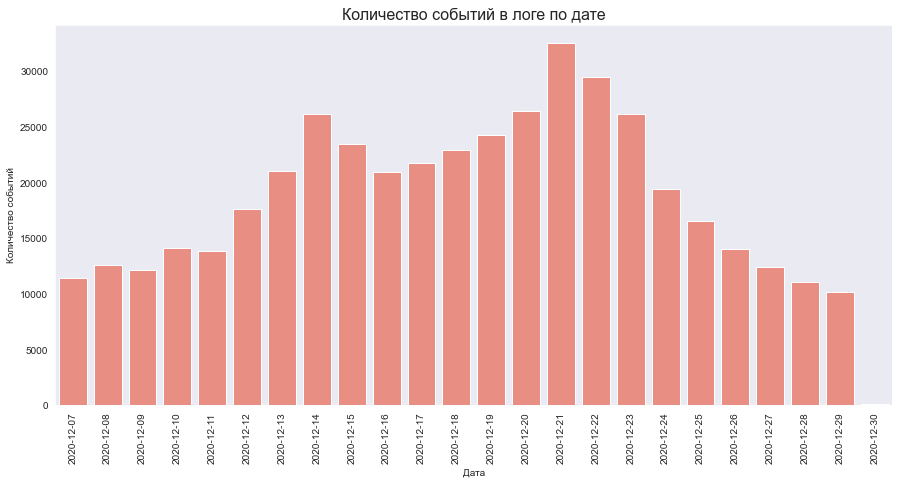

In [7]:
# Посмотрим количество событий в логе во времени
events_date_count = events.groupby(events['event_dt'].dt.date).agg({'event_name': 'count'}).reset_index()
events_date_count.columns = ['event_dt', 'n_events']
events_date_count

plt.figure(figsize=(15,7))
sns.set_style('dark')
sns.barplot(data=events_date_count, x='event_dt', y='n_events', color="salmon")
plt.title('Количество событий в логе по дате', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation= 90)
plt.show()

Данные обрываются на 30.12.2020, причем полные данные только до 29.12.2020, а должны были быть до 04.01.2021 по условию технического задания. Скорее всего произошел сбой при выгрузке или записи данных. Пользователи которые смогут "дожить" до 14 дней зарегистрируются не позднее 15.12.2020.

In [8]:
# Смотрим маркейтинговые событие, которые попадают на даты проведение нашего теста
mk_events.query('start_dt <= "2021-01-04" & finish_dt >= "2020-12-07"')

,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
10,cis new year gift lottery,cis,2020-12-30,2021-01-07


Возникают вопросы о корректности проведения тестирования так как маркейтинговое событие "christmas&new year promo" которое проводилось в регионе EU и пересекалось по времени с нашим тестом.

In [9]:
# Проверим минимальную и максимальную даты регистрации пользователей
print('Минимальная дата:', users['first_date'].min())
print('Максимальная дата:', users['first_date'].max())

Минимальная дата: 2020-12-07 00:00:00
Максимальная дата: 2020-12-23 00:00:00


Так как в техническом задании указано, что дата остановки набора новых пользователей: 2020-12-21, то удалим пользователей, которые зарегистрировались позже.

In [10]:
# Срез с 2020-12-07 по 2020-12-21 включительно
new_users = users.query('first_date <= "2020-12-21"')
print('Период лога:', new_users['first_date'].max() - new_users['first_date'].min())

Период лога: 14 days 00:00:00


Так же оставим только пользователей из региона EU чего требует техническое задание

In [11]:
# Срез по EU пользователям
new_users = new_users.query('region == "eu"')
new_users['region'].value_counts()

eu    42340
Name: region, dtype: int64

In [12]:
# Смерджим новых пользователей из региона EU с информацией об участниках тестов
users_merge = new_users.merge(participants, on='user_id', how='left').dropna()
users_merge.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,eu,pc,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,eu,pc,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,eu,iphone,B,interface_eu_test
7,E6DE857AFBDC6102,2020-12-07,eu,pc,B,recommender_system_test
8,E6DE857AFBDC6102,2020-12-07,eu,pc,B,interface_eu_test


In [13]:
# Смотрим разбитие пользователей по тесту
users_merge['ab_test'].value_counts()

interface_eu_test          10565
recommender_system_test     6351
Name: ab_test, dtype: int64

В нашем тесте 6351 пользователь, что отвечает ожидаемому значению по техническому заданию.

In [14]:
# Проверка доли участников теста относительно новых пользователей региона EU
r_s_t = users_merge[users_merge['ab_test'] == 'recommender_system_test'] #наш тест
print(
    'Доля участников теста относительно новых пользователей из региона "Европа": {:.2f}%'.format(
        len(r_s_t)/len(new_users)*100
    )
)

Доля участников теста относительно новых пользователей из региона "Европа": 15.00%


Доля участников теста удовлетворяет условию технического задания.

In [15]:
# Проверим пользователей на пересечение тестов.
twotests_users = users_merge.groupby('user_id').agg({'ab_test': 'nunique'}).reset_index()
twotests_users.query('ab_test > 1').shape[0]

1602

Обнаружено, что 1602 пользователя участвовали в двух тестах одновременно, что второй раз ставит под вопрос корректности проведения теста.

In [16]:
# Проверка пользователей на участие в двух группах теста.
twogroup_users = r_s_t.groupby('user_id').agg({'group': 'nunique'}).reset_index()
twogroup_users.query('group > 1').shape[0]

0

Пользователей попавших одновременно в контрольную и тестовую группы не обнаружено.

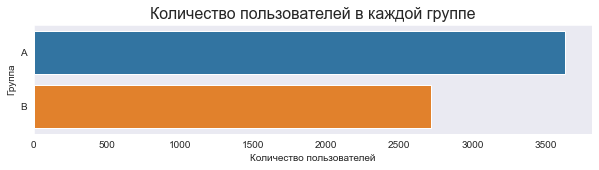

Соотношение групп:
Группа А: 57%
Группа B: 43%


In [17]:
# Распределение пользователей по группам теста
group_users = r_s_t.groupby('group').agg({'user_id': 'count'})

# Визуализируем
plt.figure(figsize=(10,2))
sns.set_style('dark')
sns.barplot(data=group_users, x='user_id', y=group_users.index, orient='h')
plt.title('Количество пользователей в каждой группе', fontsize=16)
plt.xlabel('Количество пользователей')
plt.ylabel('Группа')
plt.show()

print('Соотношение групп:')
print('Группа А: {}%'.format(round(len(r_s_t.query('group == "A"'))/len(r_s_t)*100)))
print('Группа B: {}%'.format(round(len(r_s_t.query('group == "B"'))/len(r_s_t)*100)))

Группы теста распределены не равномерно. Есть перекос в сторону контрольной группы, но так как в техническом задании нам не сказано какое должно быть соотношение контрольной и тестовой группы предположим, что данное соотношение допустимо.

<b>Предварительные выводы:</b>
* Проведена проверка на соответствие техническому заданию:
    * Оставили пользователей зарегистрировавшихся с 07.12.2020 по 21.12.2020,
    * Оставили пользователей только из региона EU,
    * Доля участников теста относительно новых пользователей из региона EU соответствует 15%,
    * Количество участников теста равна 6351, что удовлетворяет условию,
    * Только пользователи зарегистрировавшиеся до 15.12.2020 "доживут" до 14 дней.
* Возникают вопросы к корректности проведения теста из-за пересечения дат теста с маркетинговым событием "christmas&new year promo" который проводился для региона EU. А целевая аудитория нашего теста именно от туда.
* Возникают вопросы к корректности проведения теста из-за пересечения аудитории с конкурирующим тестом. Обнаружено, что 1602 пользователя участвовали в двух тестах одновременно.
* Группы теста распределены не равномерно: 57/43% соответственно.

# Исследовательский анализ данных

## Количество событий на пользователя

In [18]:
# Добавим к данным с участниками тестов информацию о событиях.
ab_test = pd.merge(r_s_t, events, on='user_id', how='left')
ab_test.head(2)

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,eu,pc,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,eu,pc,A,recommender_system_test,2020-12-07 21:52:07,login,NaN


In [19]:
# Проверим пустые значения в event_name
ab_test['event_name'].isna().sum()
print('Пользователей A/B-теста теста не имеющие данные о событиях:', ab_test['event_name'].isna().sum())
print(
    'Доля от общего числа пользователей:', 
    round(ab_test['event_name'].isna().sum()/r_s_t['user_id'].nunique()*100, 2),
    '%'
)
ab_test[ab_test['event_name'].isna()].head(2)

Пользователей A/B-теста теста не имеющие данные о событиях: 2870
Доля от общего числа пользователей: 45.19 %


,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
2,E6DE857AFBDC6102,2020-12-07,eu,pc,B,recommender_system_test,NaT,NaN,NaN
29,16C69ED14DA9F4A8,2020-12-07,eu,pc,B,recommender_system_test,NaT,NaN,NaN


Получается, что 45% участников нашего теста не имеют данных о событиях. Такое могло произойти либо из-за неправильной выгрузки данных и вследстии чего потери данных, либо люди попросту после быстрой регистрации на сайте даже не залогинились на нем.

In [20]:
# Выделим отдельно группы
group_a = ab_test.query('group == "A"')
group_b = ab_test.query('group == "B"')

# Добавим среднее количестов событий на пользовтаеля
eventmean_a = group_a.pivot_table(
    index=['user_id', 'event_name'], values='event_dt', aggfunc='count'
).reset_index().groupby('event_name').agg({'event_dt': 'mean'}).reset_index().round(2)
print('Среднее количество событий на пользователя в группе А:')
display(eventmean_a)

eventmean_b = group_b.pivot_table(
    index=['user_id', 'event_name'], values='event_dt', aggfunc='count'
).reset_index().groupby('event_name').agg({'event_dt': 'mean'}).reset_index().round(2)
print('Среднее количество событий на пользователя в группе B:')
display(eventmean_b)

Среднее количество событий на пользователя в группе А:


,event_name,event_dt
0,login,3.12
1,product_cart,3.10
2,product_page,3.10
3,purchase,3.04


Среднее количество событий на пользователя в группе B:


,event_name,event_dt
0,login,2.82
1,product_cart,2.68
2,product_page,2.69
3,purchase,2.65


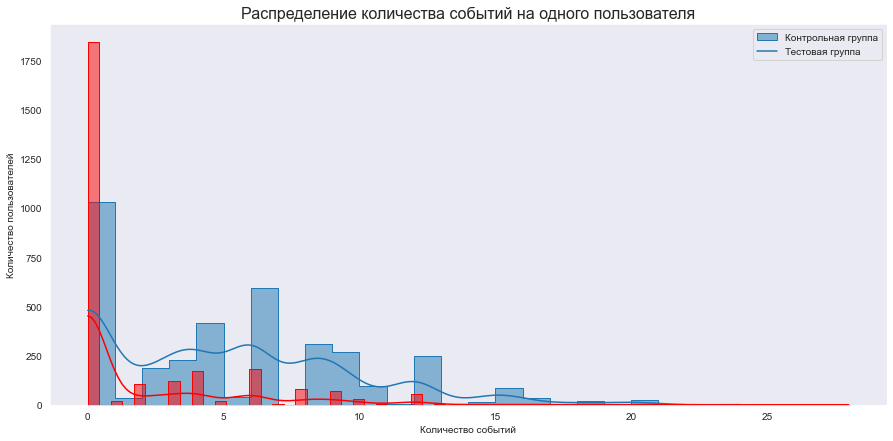

In [21]:
# Посчитаем количество событий для пользователей в двух группах
eventcount_a = group_a.pivot_table(index=['user_id'],values='event_name',aggfunc='count').reset_index()
eventcount_b = group_b.pivot_table(index=['user_id'],values='event_name',aggfunc='count').reset_index()

# Визуализируем
plt.figure(figsize=(15, 7))
sns.set_style('dark')
sns.histplot(data=eventcount_a, x='event_name', kde=True, element="step")
sns.histplot(data=eventcount_b, x='event_name', kde=True, element="step", color='red')
plt.title('Распределение количества событий на одного пользователя', fontsize=16)
plt.legend(labels=['Контрольная группа','Тестовая группа'])
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

Группы обладают разным распределением взаимодействий и разными средним количеством событий на одного пользователя.
Cреднее число взаимодействий на одного пользователя у контрольной группы больше, чем в тестовой. Пользователей без взаимодейтвий в тестовой группе на порядок выше чем в контрольной.

## Распределение событий по дням

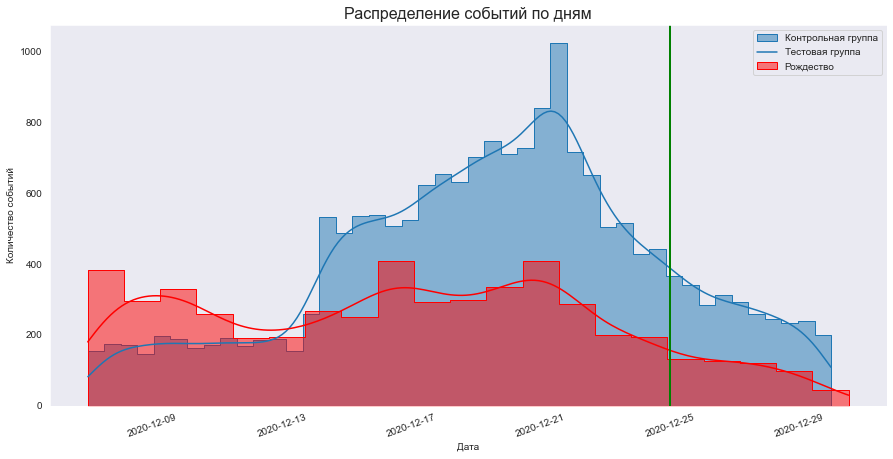

In [22]:
# Визуализируем события по датам
plt.figure(figsize=(15, 7))
sns.set_style('dark')
sns.histplot(data=group_a, x='event_dt', kde=True, element="step")
sns.histplot(data=group_b, x='event_dt', kde=True, element="step", color='red')
plt.title('Распределение событий по дням', fontsize=16)
plt.ylabel('Количество событий')
plt.xticks(rotation=20)
plt.xlabel('Дата')
plt.axvline(pd.to_datetime('2020-12-25'), color='green', linewidth=2)
plt.legend(labels=['Контрольная группа','Тестовая группа', 'Рождество'])
plt.show()

После запуска теста тестовая группа генерировала событий больше, чем контрольная. Но после 13.12.2020 контрольная группа на голову вырвалась вперед и генерировала событий больше тестовой вплоть до завершения теста.
Помимо этого, можно подметить, что факт рождества сам-по-себе потенциально может быть признаком роста продаж, так как люди покупают подарки перед праздником. Этот факт так же может влиять на результаты тестирования.

## Воронка конверсии

In [23]:
# Создадим таблицу с результатами тестов по каждому событию и разбивкой по группам
funnel_data = ab_test.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
funnel_data = funnel_data.sort_values(by='A', ascending=False).reindex(['login', 'product_page', 'product_cart', 'purchase'])
funnel_data

group,A,B
event_name,,
login,2604,877
product_page,1685,493
product_cart,782,244
purchase,833,249


In [24]:
# Соединим таблицу с общим количеством пользователей по группам и их воронкой событий.
group_users_t = group_users.T.rename(index={'user_id':'registration'})
conversion = pd.concat([group_users_t, funnel_data])
conversion

group,A,B
registration,3634,2717
login,2604,877
product_page,1685,493
product_cart,782,244
purchase,833,249


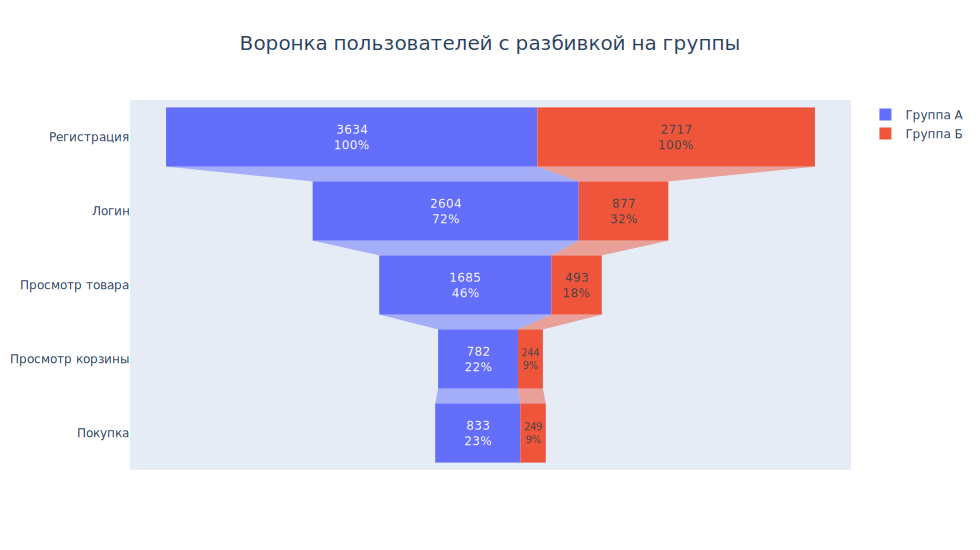

In [25]:
# Визуализация контрольной и тестовой групп
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = ['Регистрация', 'Логин', 'Просмотр товара', 'Просмотр корзины', 'Покупка'],
    x = conversion['A'],
    textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(
    name = 'Группа Б',
    orientation = "h",
    y = ['Регистрация', 'Логин', 'Просмотр товара', 'Просмотр корзины', 'Покупка'],
    x = conversion['B'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(title={'text':"Воронка пользователей c разбивкой на группы", 'font':dict(size=20), 'x':0.5})
fig.show(renderer='svg', width=980, height=550)

In [26]:
print(
    'Конверсия зарегистрировавшихся пользователей в покупки в группе А: {:.2f}%'
    .format(conversion['A']['purchase']/conversion['A']['registration']*100)
)
print(
    'Конверсия зарегистрировавшихся пользователей в покупки в группе B: {:.2f}%'
    .format(conversion['B']['purchase']/conversion['B']['registration']*100)
)
print(
    'Отношение конверсии в покупки в группе В к группе А: {:.2f}%'
    .format(
        (conversion['B']['purchase']/conversion['B']['registration'])
        /(conversion['A']['purchase']/conversion['A']['registration'])
        *100
    )
)

Конверсия зарегистрировавшихся пользователей в покупки в группе А: 22.92%
Конверсия зарегистрировавшихся пользователей в покупки в группе B: 9.16%
Отношение конверсии в покупки в группе В к группе А: 39.98%


По воронке можно понять, что есть часть пользователей которые покупают товар в обход просмотра корзины. Возможно на сайте есть функционал быстрых покупок.

Но самое главное, конверсия в покупки тестовой группы в 2,5 раза меньше по отношению к контрольной. Что свидетельствует о провале теста.

# Оценка результатов A/B-тестирования

Проверка статистической разницы долей с помощью Z-критерия:

Сформулируем гипотезы:<br>
<b>
    H0: Нет отличий между группами<br>
    H1: Отличие между группами статистически достоверно
</b>

In [27]:
# Добивам в таблицу конверсии значения по A и B группе вместе взятых.
conversion['A+B'] = conversion['A'] + conversion['B']
conversion

group,A,B,A+B
registration,3634,2717,6351
login,2604,877,3481
product_page,1685,493,2178
product_cart,782,244,1026
purchase,833,249,1082


In [28]:
# Проверка гипотезы о равенстве долей используя Z-критерий
# Задаем критический уровень статистической значимости для последующих тестов
alpha = 0.05
# Напишем функцию для проверки гипотезы
def check_hyp(eventname):
    count = conversion.loc[eventname, 'A'],
    nobs = conversion.loc[eventname, 'A+B'],
    value = 0.5
    stat, pval = proportions_ztest(count, nobs, value)
    pval=pval[0]
    print('Проверка равности долей групп А и B для cобытия: {}, p-value = {}'.format(eventname, pval))
    if pval < alpha:
        print('Отвергаем H0: между группами есть статистически значимая разница')
    else:
        print('Не отвергаем H0: группы статистически не отличаются') 

In [29]:
# Сравнение результатов контрьной и тестовой групп
for eventname in conversion.index:
    check_hyp(eventname)
    print()

Проверка равности долей групп А и B для cобытия: registration, p-value = 2.9529378206125363e-31
Отвергаем H0: между группами есть статистически значимая разница

Проверка равности долей групп А и B для cобытия: login, p-value = 3.760992009875724e-249
Отвергаем H0: между группами есть статистически значимая разница

Проверка равности долей групп А и B для cобытия: product_page, p-value = 1.5177269785999959e-204
Отвергаем H0: между группами есть статистически значимая разница

Проверка равности долей групп А и B для cобытия: product_cart, p-value = 1.3030396516354927e-86
Отвергаем H0: между группами есть статистически значимая разница

Проверка равности долей групп А и B для cобытия: purchase, p-value = 9.849102662356382e-99
Отвергаем H0: между группами есть статистически значимая разница



Похоже, что введение новой рекомендательной системы на сайте никак увеличело показатели конферсии на каждом этапе на 10% как таково требовало техническое задание. Тест провален.

# Выводы

<b>По результатам исследования обнаружили, что:</b>
* в файле с событиями, данные оборвались на 30.12.2020, полные данные были до 29.12.2020, а должны были быть до 04.01.2021. Скорее всего произошел сбой в записи или выгрузке событий;
* в файле с новыми пользователями, дата остановки набора новых пользователей была 23.12.2020, а не 21.12.2021. Было больше данных;
* Из-за неполных данных пользователи которые смогут "дожить" до 14 дней зарегистрируются не позднее 15.12.2020;
* Имеется пересечение дат проведения A/B-теста с маркетинговым событием "christmas&new year promo", которое проводилось для нашей целевой аудитории.
* Имеется пересечение аудитории с конкурирующим тестом: 1602 пользователя участвовало в двух тестах одновременно;
* Группы теста распределены не равномерно: 57/43% соответственно, обладают разным распределением взаимодействий и разными средним количеством событий на одного пользователя.

<b>По результатм анализа A/B-теста</b> конверсия в покупки тестовой группы в 2,5 раза меньше по отношению к контрольной. Конверсия в покупки после введения новой рекомендаельной системы снизилась приблизительно с 22.92 до 9.16%, т.е более чем на 13.5%.
Новая рекомендательная система - неуспешна.

<b>Рекомендации:</b>
Так как очень много различных факторов ставят под сомнения результаты теста, особенно обрыв данных - воспринимать результаты теста как максимально правдивые не стоит. Если это тестирование было очень важно для бизнеса и на него возлагались определеннные ожидания стоит решить проблемы с сбором данных и провести тест заново.